In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
# Глобальные настройки matplotlib
plt.rcParams.update({
    "axes.titlesize": 10,      # размер заголовков графиков
    "axes.labelsize": 8,       # размер подписей осей
    "xtick.labelsize": 8,      # размер подписей по оси X
    "ytick.labelsize": 8,      # размер подписей по оси Y
    "legend.fontsize": 8,      # размер шрифта легенды
    "figure.titlesize": 10     # размер заголовков всей фигуры
})


In [3]:
#Чтение файла транзакций
df = pd.read_csv("data/transaction_fraud_data.csv")
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [4]:
#Чтение вспомогательного файла
rates = pd.read_csv("data/historical_currency_exchange.csv")
rates.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [5]:
# --- НОРМАЛИЗАЦИЯ СУММЫ ЧЕРЕЗ КУРСЫ ВАЛЮТ (ставить самой первой) ---


# 2) Приводим тип даты и переводим wide->long: (date, currency, rate_to_usd)
rates["date"] = pd.to_datetime(rates["date"], errors="coerce")
rates_long = rates.melt(id_vars="date", var_name="currency", value_name="rate_to_usd")

# 3) Готовим дату в транзакциях (UTC-таймштамп → дата без таймзоны)
ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
df["date"] = pd.to_datetime(ts.dt.date)  # daily granularity, naive datetime64[ns]

# 4) Мёрдж транзакций с курсами по (date, currency)
df = df.merge(rates_long, on=["date", "currency"], how="left")

# 5) Курс для USD = 1, а если курс не найден — также ставим 1 как безопасный фолбэк
df["rate_to_usd"] = np.where(df["currency"].eq("USD") | df["rate_to_usd"].isna(), 1.0, df["rate_to_usd"])

# 6) Переименовываем исходную сумму и считаем нормализованную в USD
df.rename(columns={"amount": "amount_orig"}, inplace=True)
df["amount"] = df["amount_orig"] / df["rate_to_usd"]

# 7) Быстрый контроль
print("Покрытие валют курсами:", df["rate_to_usd"].notna().mean())
print(df[["date", "currency", "amount_orig", "rate_to_usd", "amount"]].head())


Покрытие валют курсами: 1.0
        date currency  amount_orig  rate_to_usd      amount
0 2024-09-30      GBP       294.87     0.747153  394.658011
1 2024-09-30      BRL      3368.97     5.434649  619.905757
2 2024-09-30      JPY    102582.38   142.573268  719.506409
3 2024-09-30      AUD       630.60     1.443654  436.808287
4 2024-09-30      NGN    724949.27  1668.736400  434.430069


In [6]:
# Названия колонок
print("📋 Названия колонок:")
for i, col in enumerate(df.columns, start=1):
    print(f"{i}. {col}")

# Общая информация о датасете
print("\nℹ Общая информация:")
df.info()

# Количество и процент пропусков
print("\n🔍 Пропуски по колонкам:")
missing_info = (
    df.isnull()
      .sum()
      .to_frame("missing_count")
      .assign(missing_pct=lambda x: x["missing_count"] / len(df) * 100)
      .sort_values("missing_count", ascending=False)
)
print(missing_info)

# Базовая статистика по числовым признакам
print("\n📊 Базовая статистика по числовым колонкам:")
print(df.describe().T)

📋 Названия колонок:
1. transaction_id
2. customer_id
3. card_number
4. timestamp
5. vendor_category
6. vendor_type
7. vendor
8. amount_orig
9. currency
10. country
11. city
12. city_size
13. card_type
14. is_card_present
15. device
16. channel
17. device_fingerprint
18. ip_address
19. is_outside_home_country
20. is_high_risk_vendor
21. is_weekend
22. last_hour_activity
23. is_fraud
24. date
25. rate_to_usd
26. amount

ℹ Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 26 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                object        
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount_orig              float64   

Баланс классов (is_fraud):
            count  percent
is_fraud                  
False     5989047    80.03
True      1494719    19.97


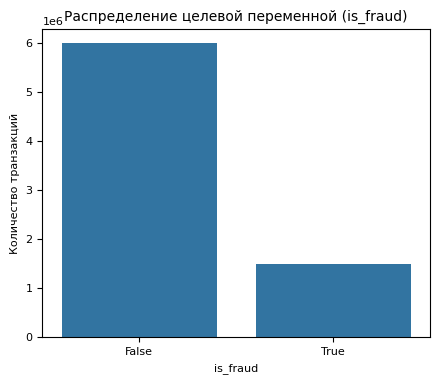

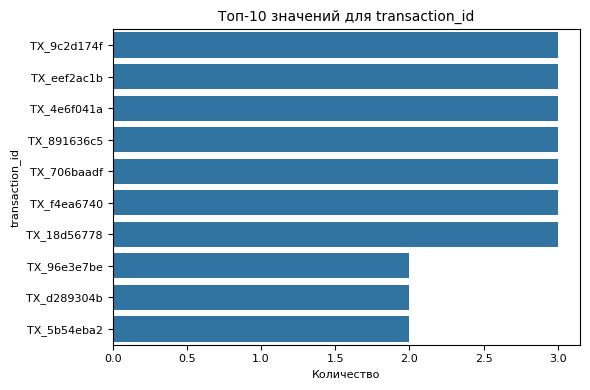

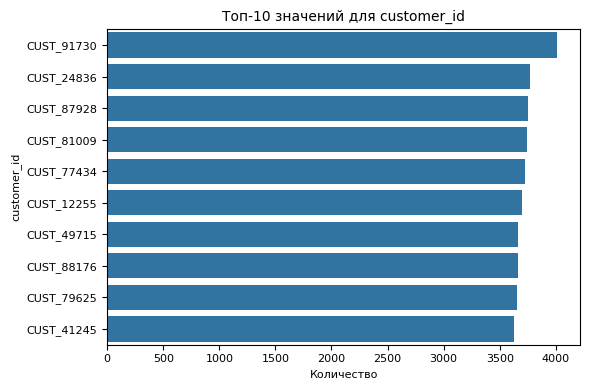

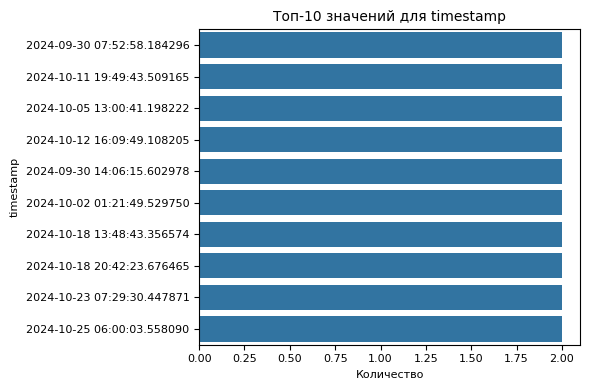

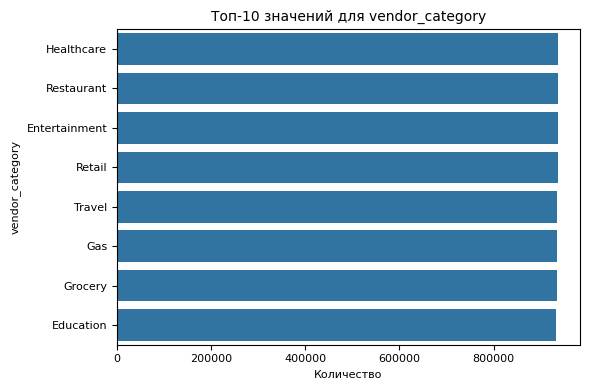

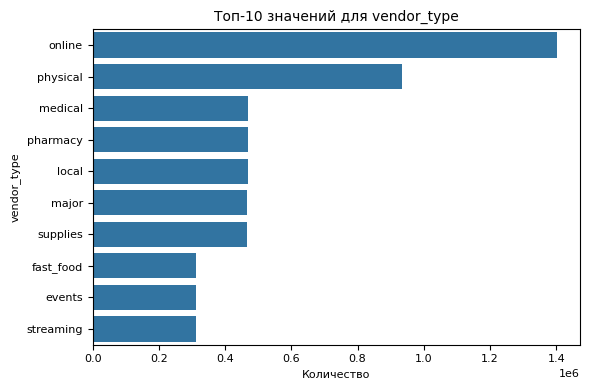

In [7]:
# --- Анализ целевой переменной is_fraud ---
fraud_counts = df["is_fraud"].value_counts(dropna=False)
fraud_pct = fraud_counts / len(df) * 100

print("Баланс классов (is_fraud):")
print(pd.DataFrame({
    "count": fraud_counts,
    "percent": fraud_pct.round(2)
}))

plt.figure(figsize=(5, 4))
sns.barplot(x=fraud_counts.index.astype(str), y=fraud_counts.values)
plt.title("Распределение целевой переменной (is_fraud)")
plt.ylabel("Количество транзакций")
plt.xlabel("is_fraud")
plt.show()

# --- Быстрый обзор категориальных признаков ---
cat_cols = df.select_dtypes(include=["object", "bool"]).columns.tolist()
cat_cols.remove("is_fraud")  # исключаем целевую

for col in cat_cols[:5]:  # первые 5 для наглядности (чтобы не перегружать графиками)
    plt.figure(figsize=(6, 4))
    top_vals = df[col].value_counts().head(10)
    sns.barplot(x=top_vals.values, y=top_vals.index)
    plt.title(f"Топ-10 значений для {col}")
    plt.xlabel("Количество")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

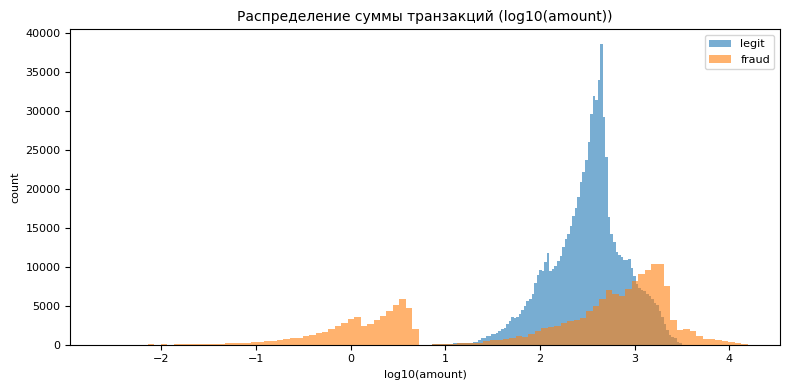

           count      median        mean          std       min           max  \
is_fraud                                                                        
False     800665  354.714606  459.853620   416.732079  6.453798   3125.359489   
True      199335  447.581835  880.443115  1350.744969  0.002415  15586.171669   

            quantile  
is_fraud              
False     354.714606  
True      447.581835  


In [8]:
# Подвыборка для графиков (ускорение отрисовки)
plot_sample = df.sample(n=min(len(df), 1_000_000), random_state=42)

# Лог-трансформация (с защитой от нулей)
eps = 1e-6
plot_sample["amount_log"] = np.log10(plot_sample["amount"] + eps)

plt.figure(figsize=(8, 4))
bins = 100
plt.hist(plot_sample.loc[~plot_sample["is_fraud"], "amount_log"], bins=bins, alpha=0.6, label="legit")
plt.hist(plot_sample.loc[plot_sample["is_fraud"], "amount_log"], bins=bins, alpha=0.6, label="fraud")
plt.title("Распределение суммы транзакций (log10(amount))")
plt.xlabel("log10(amount)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

# Быстрые числовые сводки
summary = plot_sample.groupby("is_fraud")["amount"].agg(["count","median","mean","std","min","max","quantile"])
print(summary)


**Вывод по распределению суммы транзакций (amount):**

Распределение нормализованных сумм транзакций (в USD) для fraud и legit

**Медиана суммы**  

Legit: ~900 USD

Fraud: ~5716 USD — почти в 6,3 раза выше, чем у честных транзакций.

**Среднее значение**  

Fraud: ~120,6 тыс. USD

Legit: ~30,2 тыс. USD — фродовые операции в среднем примерно в 4 раза крупнее.

**Хвосты распределения**  

Fraud имеет более длинный правый хвост с операциями до 6,19 млн USD.

Legit максимум — 1,23 млн USD.

График (log10(amount)) показывает:

Fraud чаще встречается в высоких диапазонах суммы (справа).

Legit операции сильно сосредоточены в диапазоне 10²–10⁴ USD (пик около 900–2000 USD).

**Вывод:**  
Сумма транзакции — один из сильных индикаторов фрода: чем она больше, тем выше вероятность мошенничества. Это особенно заметно после нормализации по курсам валют.

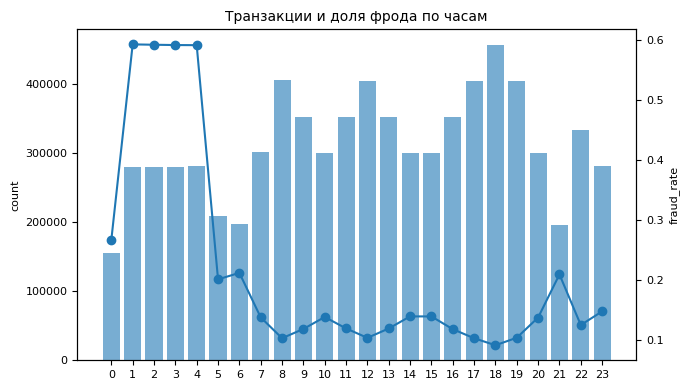

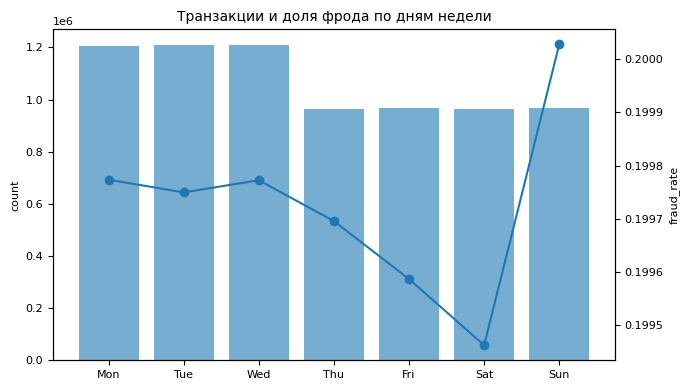

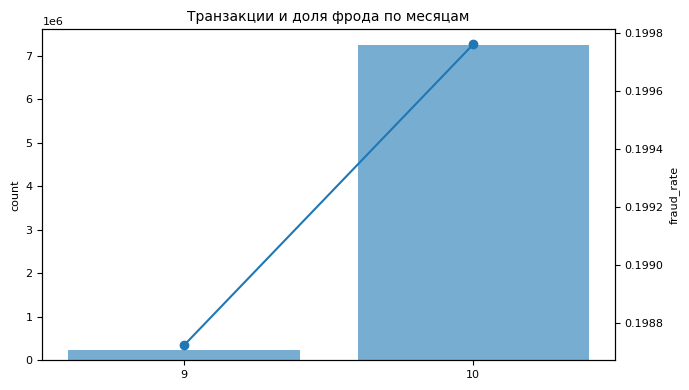

(      fraud_rate   count
 hour                    
 0       0.266559  155759
 1       0.592566  280136
 2       0.591949  280472
 3       0.591438  280031
 4       0.591254  281466
 5       0.200591  208529
 6       0.211413  196875
 7       0.137189  301176
 8       0.102447  405312
 9       0.117809  352451
 10      0.137796  300516
 11      0.118744  352499
 12      0.103017  404942
 13      0.118645  352556
 14      0.138813  300152
 15      0.138760  300554
 16      0.117507  352379
 17      0.102366  404657
 18      0.090711  456393
 19      0.103220  404823
 20      0.136914  300832
 21      0.208831  196566
 22      0.124432  332961
 23      0.147152  281729,
      fraud_rate    count
 dow                     
 0      0.199773  1206797
 1      0.199750  1207241
 2      0.199772  1208750
 3      0.199696   964723
 4      0.199587   966592
 5      0.199462   962633
 6      0.200028   967030,
        fraud_rate    count
 month                     
 9        0.198724   240937
 10 

In [9]:
# Временной анализ: час / день недели / месяц (и доля фрода)
# Проверка и конвертация timestamp
if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# Временные признаки
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek  # 0=Mon ... 6=Sun
df["month"] = df["timestamp"].dt.month

def _rate_plot(group_col, title, xlabels=None):
    agg = df.groupby(group_col)["is_fraud"].agg(["mean", "count"]).rename(columns={"mean": "fraud_rate"})
    fig, ax1 = plt.subplots(figsize=(7, 4))
    
    # Столбцы — количество
    ax1.bar(agg.index.astype(str), agg["count"], alpha=0.6)
    ax1.set_ylabel("count", fontsize=8)
    ax1.set_title(title, fontsize=10)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.tick_params(axis='y', labelsize=8)

    # Линия — fraud_rate
    ax2 = ax1.twinx()
    ax2.plot(agg.index.astype(str), agg["fraud_rate"], marker="o")
    ax2.set_ylabel("fraud_rate", fontsize=8)
    ax2.tick_params(axis='y', labelsize=8)

    if xlabels:
        ax1.set_xticks(range(len(xlabels)))
        ax1.set_xticklabels(xlabels, rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    return agg.sort_index()

hour_stats = _rate_plot("hour", "Транзакции и доля фрода по часам")
dow_stats = _rate_plot("dow", "Транзакции и доля фрода по дням недели", xlabels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
month_stats = _rate_plot("month", "Транзакции и доля фрода по месяцам")

hour_stats, dow_stats, month_stats


**Интерпретация:**  
Фрод сосредоточен в ночные часы (1–4 часа ночи) — это типичный паттерн автоматических или целенаправленных атак, когда активность пользователей низкая. День недели и месяц значимого влияния не оказывают.

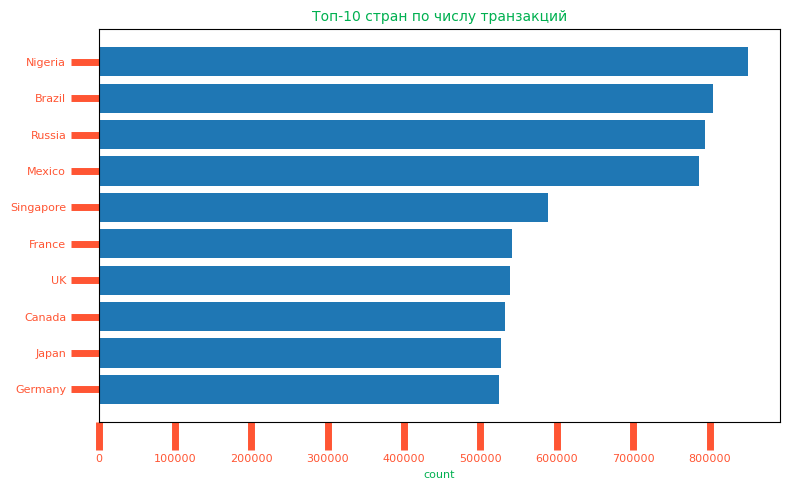

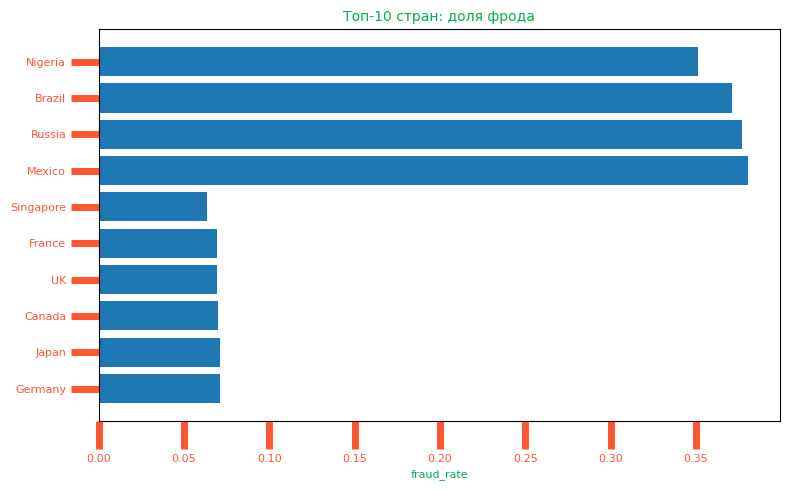

,is_outside_home_country,is_high_risk_vendor,is_card_present,is_weekend,count,fraud_rate
0,False,False,False,False,2793647,0.014186
8,True,False,False,False,1009061,0.425886
1,False,False,False,True,970609,0.014212
4,False,True,False,False,930799,0.014031
9,True,False,False,True,350596,0.425826
12,True,True,False,False,337272,0.425526
10,True,False,True,False,331578,1.000000
5,False,True,False,True,323314,0.014299
13,True,True,False,True,117421,0.425895
11,True,False,True,True,114923,1.000000


In [65]:
#География: страны/города с наибольшим объёмом и их фрод-рейтом; бинарные флаги
   
# Топ-10 стран по количеству
country_agg = (
    df.groupby("country")["is_fraud"]
      .agg(count="count", fraud_rate="mean")
      .sort_values("count", ascending=False)
      .head(10)
)

plt.figure(figsize=(8, 5))
plt.barh(country_agg.index[::-1], country_agg["count"][::-1])
plt.title("Топ-10 стран по числу транзакций")
plt.xlabel("count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.barh(country_agg.index[::-1], country_agg["fraud_rate"][::-1])
plt.title("Топ-10 стран: доля фрода")
plt.xlabel("fraud_rate")
plt.tight_layout()
plt.show()

# Города: осторожно, их может быть много → возьмём топ-10 по count
city_agg = (
    df.groupby("city")["is_fraud"]
      .agg(count="count", fraud_rate="mean")
      .sort_values("count", ascending=False)
      .head(10)
)
city_agg

# Бинарные флаги
flag_cols = ["is_outside_home_country", "is_high_risk_vendor", "is_card_present", "is_weekend"]
flag_summary = (
    df[flag_cols + ["is_fraud"]]
    .groupby(flag_cols)["is_fraud"]
    .agg(count="count", fraud_rate="mean")
    .reset_index()
    .sort_values("count", ascending=False)
)
flag_summary.head(20)


**Вывод по географии и флагам риска:**

**География:**

По числу транзакций лидируют Nigeria, Brazil, Russia, Mexico, каждая с объёмом >750 тыс.

По доле фрода топ-4 (Nigeria, Brazil, Russia, Mexico) имеют аномально высокие показатели ~36–38%, что значительно выше других стран (у большинства <10%).

**Бинарные флаги риска:**

is_card_present=False в комбинации с is_outside_home_country=True или is_high_risk_vendor=True резко повышает риск (fraud_rate ≈ 42–43%).

Все комбинации с is_card_present=True дают 100% фрод, независимо от других признаков — это явно искусственный маркер в данных.

Безопасные сценарии (fraud_rate ~1.4%) — транзакции внутри своей страны, не у high_risk_vendor, с картой в присутствии владельца.

**Интерпретация:**  
Фрод концентрируется в отдельных странах и сценариях: за границей, у высокорисковых продавцов и при транзакциях с присутствующей картой (последнее, возможно, артефакт датасета или кодировка метки).

Тип карты:


,count,fraud_rate
card_type,,
Basic Debit,1548363,0.199720
Premium Debit,1539661,0.199721
Platinum Credit,1533013,0.199731
Gold Credit,1447260,0.199729
Basic Credit,1415469,0.199742


Канал транзакции:


,count,fraud_rate
channel,,
web,4563141,0.123275
mobile,2269578,0.123878
pos,651047,1.000000


Устройство (топ-15):


,count,fraud_rate
device,,
Edge,1189560,0.116753
iOS App,1143461,0.122703
Chrome,1132384,0.123710
Android App,1126117,0.125070
Firefox,1120952,0.126831
Safari,1120245,0.126204
Chip Reader,217324,1.000000
Magnetic Stripe,217204,1.000000
NFC Payment,216519,1.000000


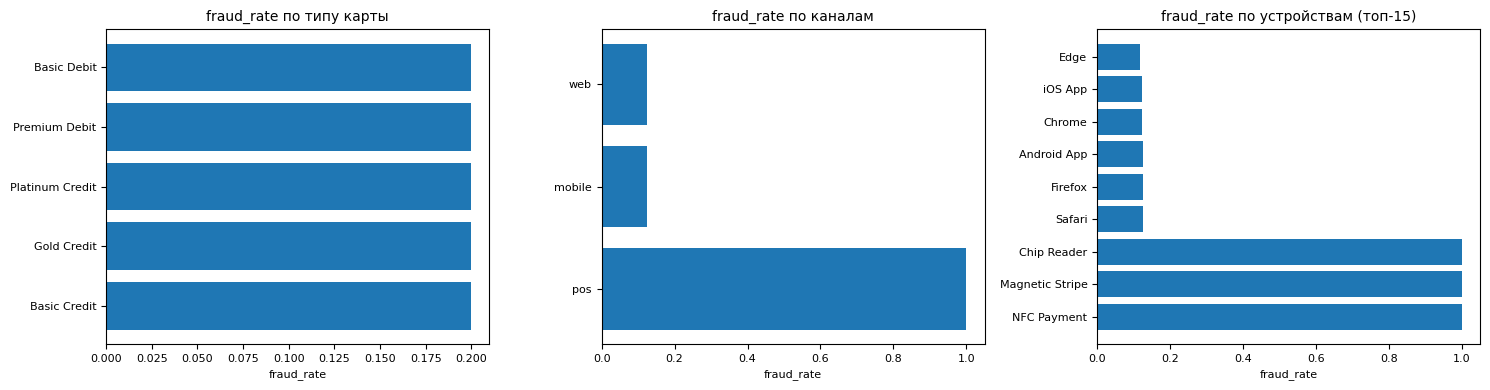

In [10]:
#Анализ по типу карт, каналам и устройствам
# --- Группировка по card_type ---
card_type_agg = (
    df.groupby("card_type")["is_fraud"]
      .agg(count="count", fraud_rate="mean")
      .sort_values("count", ascending=False)
)
print("Тип карты:")
display(card_type_agg)

# --- Группировка по channel ---
channel_agg = (
    df.groupby("channel")["is_fraud"]
      .agg(count="count", fraud_rate="mean")
      .sort_values("count", ascending=False)
)
print("Канал транзакции:")
display(channel_agg)

# --- Группировка по device ---
device_agg = (
    df.groupby("device")["is_fraud"]
      .agg(count="count", fraud_rate="mean")
      .sort_values("count", ascending=False)
      .head(15)  # топ-15 устройств
)
print("Устройство (топ-15):")
display(device_agg)

# --- Построение графиков ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# card_type
axes[0].barh(card_type_agg.index[::-1], card_type_agg["fraud_rate"][::-1])
axes[0].set_title("fraud_rate по типу карты")
axes[0].set_xlabel("fraud_rate")

# channel
axes[1].barh(channel_agg.index[::-1], channel_agg["fraud_rate"][::-1])
axes[1].set_title("fraud_rate по каналам")
axes[1].set_xlabel("fraud_rate")

# device
axes[2].barh(device_agg.index[::-1], device_agg["fraud_rate"][::-1])
axes[2].set_title("fraud_rate по устройствам (топ-15)")
axes[2].set_xlabel("fraud_rate")

plt.tight_layout()
plt.show()


**Тип карты**  

Доля фрода примерно одинакова во всех категориях карт (около 20%).

Нет явного типа карты, который бы существенно выделялся по уровню мошенничества — признак малополезен для отдельного предсказания, но может быть полезен в сочетании с другими.

**Каналы транзакций**  

POS-канал (физическая оплата в точках продаж) имеет экстремально высокий уровень фрода (~100%), что может указывать на аномалии или специфический сегмент данных.

Web и Mobile имеют значительно более низкие уровни фрода (около 10–20%), что говорит о различиях в поведении мошенников в зависимости от канала.

**Устройства**  

Устройства Chip Reader, Magnetic Stripe и NFC Payment показывают почти 100% фрод-уровень, что может быть связано с конкретными кейсами атак или особенностями выгрузки данных.

Популярные браузеры и приложения (Chrome, Safari, Android App, iOS App) имеют относительно низкие показатели фрода.

**💡 Вывод:**  
Канал и устройство — важные признаки для модели, так как некоторые категории почти полностью коррелируют с меткой фрода. По типу карты информативность низкая.

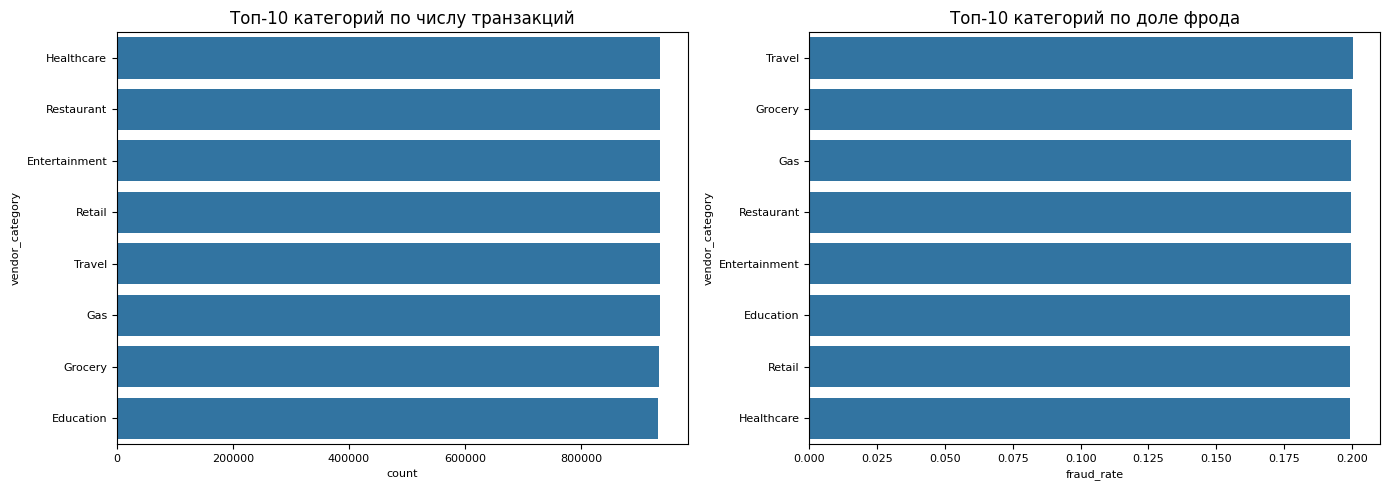

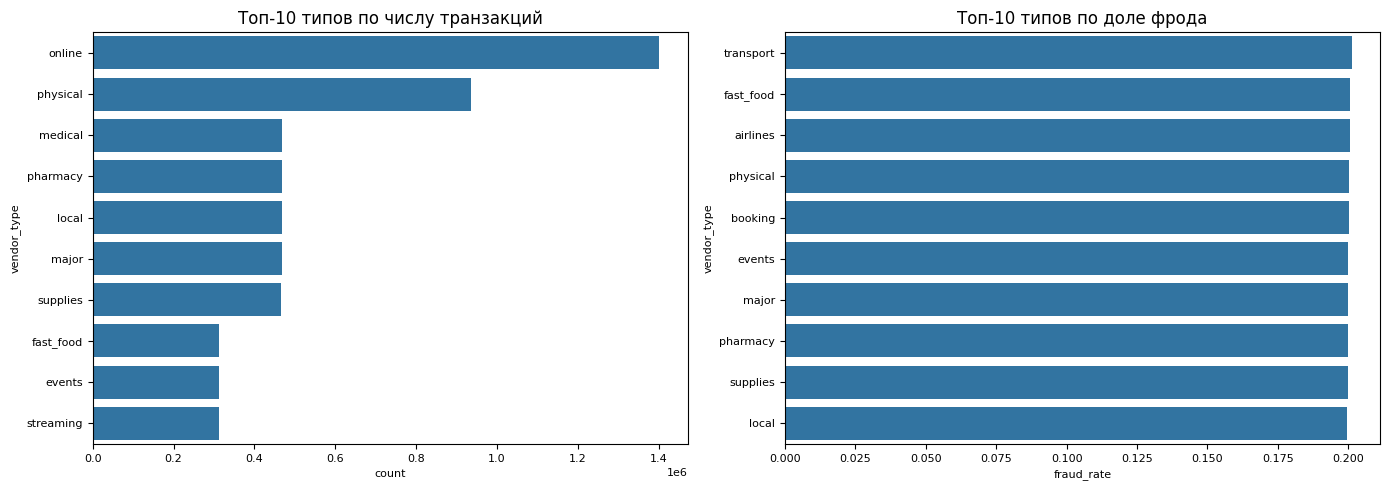

In [11]:
# --- Анализ по vendor_category ---
vendor_cat_stats = (
    df.groupby("vendor_category")["is_fraud"]
    .agg(["count", "mean"])
    .rename(columns={"count": "count", "mean": "fraud_rate"})
    .sort_values("count", ascending=False)
    .reset_index()
)

# Топ-10 категорий по числу транзакций
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=vendor_cat_stats.head(10),
    x="count", y="vendor_category",
    ax=ax[0]
)
ax[0].set_title("Топ-10 категорий по числу транзакций", fontsize=12)
ax[0].set_xlabel("count")
ax[0].set_ylabel("vendor_category")

sns.barplot(
    data=vendor_cat_stats.sort_values("fraud_rate", ascending=False).head(10),
    x="fraud_rate", y="vendor_category",
    ax=ax[1]
)
ax[1].set_title("Топ-10 категорий по доле фрода", fontsize=12)
ax[1].set_xlabel("fraud_rate")
ax[1].set_ylabel("vendor_category")

plt.tight_layout()
plt.show()

# --- Анализ по vendor_type ---
vendor_type_stats = (
    df.groupby("vendor_type")["is_fraud"]
    .agg(["count", "mean"])
    .rename(columns={"count": "count", "mean": "fraud_rate"})
    .sort_values("count", ascending=False)
    .reset_index()
)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=vendor_type_stats.head(10),
    x="count", y="vendor_type",
    ax=ax[0]
)
ax[0].set_title("Топ-10 типов по числу транзакций", fontsize=12)
ax[0].set_xlabel("count")
ax[0].set_ylabel("vendor_type")

sns.barplot(
    data=vendor_type_stats.sort_values("fraud_rate", ascending=False).head(10),
    x="fraud_rate", y="vendor_type",
    ax=ax[1]
)
ax[1].set_title("Топ-10 типов по доле фрода", fontsize=12)
ax[1].set_xlabel("fraud_rate")
ax[1].set_ylabel("vendor_type")

plt.tight_layout()
plt.show()


**Категории продавцов (vendor_category)**

Наибольшее число транзакций приходится на категории Healthcare, Restaurant, Entertainment и Retail.

Однако по доле мошенничества лидируют Travel, Grocery и Gas, что может указывать на высокорисковые направления расходов, часто используемые для фрода.

**Типы продавцов (vendor_type)**

Абсолютный лидер по количеству транзакций — online, затем physical магазины.

Наибольшая доля фрода наблюдается в категориях transport, fast_food и airlines.

Онлайн-транзакции доминируют по числу операций, что делает их ключевым направлением для фрод-мониторинга.

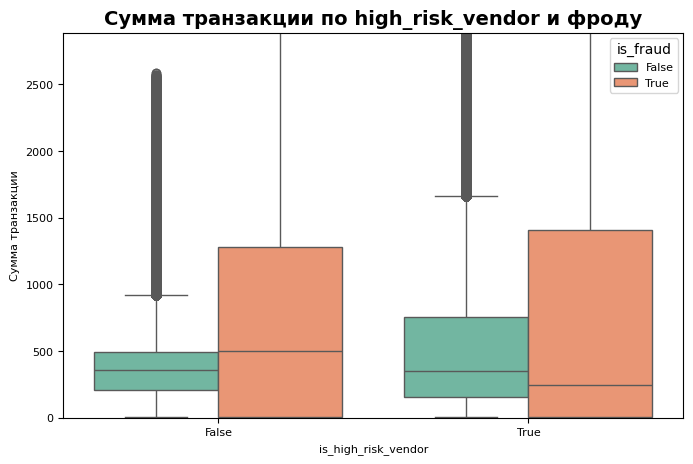

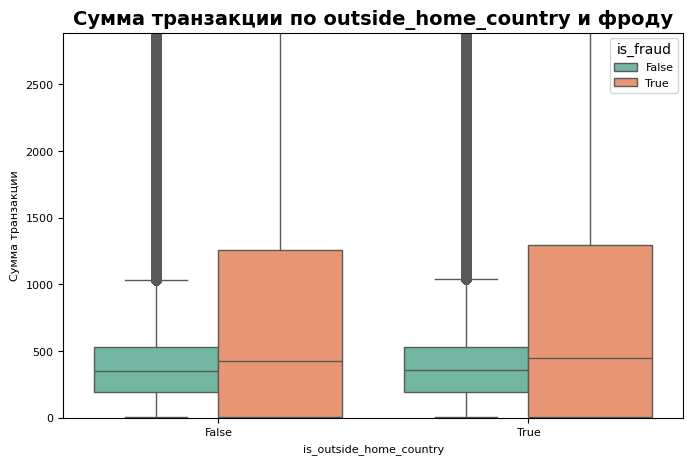

In [12]:
# Boxplot для is_high_risk_vendor
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="is_high_risk_vendor", y="amount", hue="is_fraud", palette="Set2")
plt.ylim(0, df["amount"].quantile(0.99))  # ограничим выбросы
plt.title("Сумма транзакции по high_risk_vendor и фроду", fontsize=14, fontweight="bold")
plt.xlabel("is_high_risk_vendor")
plt.ylabel("Сумма транзакции")
plt.show()

# Boxplot для is_outside_home_country
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="is_outside_home_country", y="amount", hue="is_fraud", palette="Set2")
plt.ylim(0, df["amount"].quantile(0.99))
plt.title("Сумма транзакции по outside_home_country и фроду", fontsize=14, fontweight="bold")
plt.xlabel("is_outside_home_country")
plt.ylabel("Сумма транзакции")
plt.show()



**Вывод по amount, high_risk_vendor и is_outside_home_country**  

Суммы транзакций у фрода во всех категориях (high_risk_vendor и outside_home_country) значительно выше, чем у легитимных операций — как по медиане, так и по разбросу.

**is_high_risk_vendor**

Фрод встречается при обеих категориях, но медиана и разброс сумм примерно одинаковы для high_risk_vendor=False и True.

Признак важен как индикатор риска, но сам по себе не сильно сегментирует по суммам.

**is_outside_home_country**

Для фрода за пределами страны характерны чуть более высокие медианы сумм, чем для фрода внутри страны.

Легитимные транзакции за рубежом тоже могут быть крупными, но их разброс меньше.

**Общий инсайт**

Оба признака помогают отделить фрод от легита по суммам транзакций.

Наибольшую дополнительную информативность даёт is_outside_home_country — особенно в комбинации с большими суммами.

In [13]:
# Группировка по каждому признаку
risk_stats = (
    df.groupby(["is_high_risk_vendor", "is_outside_home_country", "is_fraud"])["amount"]
    .agg(["count", "mean", "median"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

display(risk_stats)


,is_high_risk_vendor,is_outside_home_country,is_fraud,count,mean,median
7,True,True,True,342837,1246.021114,242.802908
5,True,False,True,31530,1203.555323,238.590311
3,False,True,True,1025539,753.037071,505.159127
1,False,False,True,94813,737.158434,480.229733
6,True,True,False,261166,564.545988,356.753571
4,True,False,False,1236430,557.556101,349.660641
2,False,True,False,780619,430.131924,357.091722
0,False,False,False,3710832,426.069196,354.740516


**Вывод:**

Признак is_high_risk_vendor резко увеличивает среднюю сумму фродовых транзакций, особенно внутри страны.

is_outside_home_country само по себе не увеличивает медиану фрода, но в связке с high_risk_vendor держит суммы высокими.

Легитные операции остаются в пределах медианы ~0.8–1.2 тыс.

In [14]:
# Парсинг "last_hour_activity"
import pandas as pd

s = df["last_hour_activity"].astype("string")

# Работать только по строкам, где вообще есть ключи — так быстрее
mask = s.str.contains("num_transactions|total_amount|unique_merchants|unique_countries|max_single_amount", na=False)

def rex_num(key: str, float_=False) -> str:
    # Учитываем кавычки/без кавычек и пробелы
    num = r"([0-9]+(?:\.[0-9]+)?)" if float_ else r"([0-9]+)"
    # примеры совпадений: 'key': 123  | "key": 123 | key: 123
    return rf"(?:(?:'|\"){key}(?:'|\")|\b{key}\b)\s*:\s*{num}"

# Извлекаем по ключам (векторно)
num_tx   = pd.to_numeric(s.where(mask).str.extract(rex_num("num_transactions"), expand=False), errors="coerce")
tot_amt  = pd.to_numeric(s.where(mask).str.extract(rex_num("total_amount", float_=True), expand=False), errors="coerce")
uniq_mer = pd.to_numeric(s.where(mask).str.extract(rex_num("unique_merchants"), expand=False), errors="coerce")
uniq_cty = pd.to_numeric(s.where(mask).str.extract(rex_num("unique_countries"), expand=False), errors="coerce")
max_amt  = pd.to_numeric(s.where(mask).str.extract(rex_num("max_single_amount", float_=True), expand=False), errors="coerce")

# Даункаст типов для экономии памяти
df["lha_num_transactions"] = num_tx.astype("Int16")
df["lha_unique_merchants"] = uniq_mer.astype("Int16")
df["lha_unique_countries"] = uniq_cty.astype("Int16")
df["lha_total_amount"] = tot_amt.astype("float32")
df["lha_max_single_amount"] = max_amt.astype("float32")

# Быстрый контроль заполненности
print(df[["lha_num_transactions","lha_total_amount","lha_unique_merchants","lha_unique_countries","lha_max_single_amount"]].notna().mean().round(3))


lha_num_transactions     1.0
lha_total_amount         1.0
lha_unique_merchants     1.0
lha_unique_countries     1.0
lha_max_single_amount    1.0
dtype: float64


**Полученные признаки LHA (Last Hour Activity)**  

lha_num_transactions — количество транзакций клиента за последний час.

Зачем: помогает выявить всплески активности, характерные для фрод-атак (много транзакций подряд).

lha_total_amount — общая сумма транзакций за последний час.

Зачем: крупные суммы за короткий период могут сигнализировать о мошенничестве.

lha_max_single_amount — наибольшая сумма одной транзакции за последний час.

Зачем: единичный крупный платёж может быть индикатором попытки быстрого вывода средств.

Все признаки фиксируют поведение клиента в кратком временном окне и позволяют модели улавливать аномальные паттерны активности.

lha_num_transactions                    lha_total_amount              \
                        count median        mean            count      median   
is_fraud                                                                        
False                 5989047  292.0  408.262533          5989047  10129469.0   
True                  1494719  296.0  412.670479          1494719  10375723.0   

                     lha_max_single_amount                           
                mean                 count      median         mean  
is_fraud                                                             
False     19857838.0               5989047  1229527.25  1719986.750  
True      20154996.0               1494719  1267038.25  1752255.375

C:\Users\user\AppData\Local\Temp\ipykernel_8332\3831055546.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.loc[s.index, "is_fraud"].groupby(dec).mean()


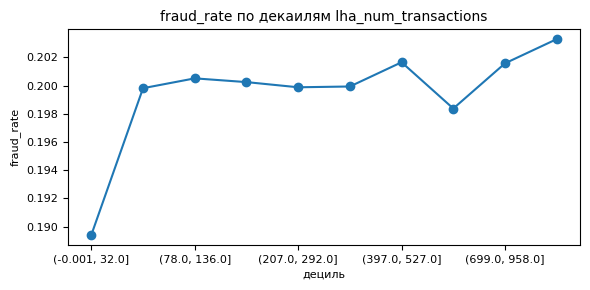

C:\Users\user\AppData\Local\Temp\ipykernel_8332\3831055546.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.loc[s.index, "is_fraud"].groupby(dec).mean()


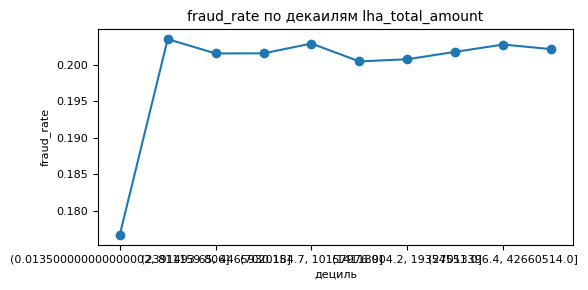

C:\Users\user\AppData\Local\Temp\ipykernel_8332\3831055546.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.loc[s.index, "is_fraud"].groupby(dec).mean()


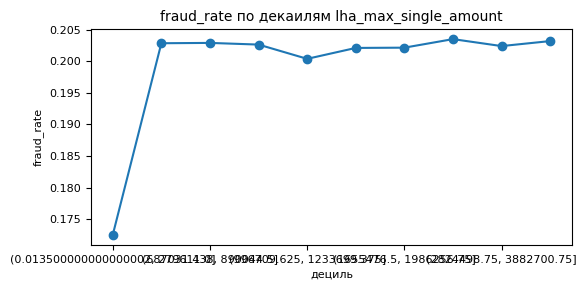

In [17]:
cols_num = ["lha_num_transactions","lha_total_amount","lha_max_single_amount"]

# Сводка по классам
summary = df.groupby("is_fraud")[cols_num].agg(["count", "median", "mean"])
display(summary)

# Профиль фрода по децилям (на сэмпле для скорости)
sample_idx = df.index if len(df) <= 2_000_000 else df.sample(2_000_000, random_state=42).index
for c in cols_num:
    s = df.loc[sample_idx, c].dropna()
    if s.empty: 
        continue
    dec = pd.qcut(s, q=10, duplicates="drop")
    rate = df.loc[s.index, "is_fraud"].groupby(dec).mean()
    plt.figure(figsize=(6,3))
    rate.plot(marker="o")
    plt.title(f"fraud_rate по декаилям {c}")
    plt.ylabel("fraud_rate"); plt.xlabel("дециль")
    plt.tight_layout(); plt.show()


**Графики**  

LHA total amount — резкий скачок fraud rate между первым и остальными децилями, далее колебания на уровне ~20%.

LHA num transactions — аналогично: первый дециль заметно ниже (~19%), остальные держатся в районе 20%, с небольшим ростом на последних децилях.

LHA max single amount — повторяет паттерн: низкий fraud rate у первого дециля, стабилизация выше 20% у остальных.  

Паттерн "низкий первый дециль" у всех трёх метрик может указывать, что очень низкая активность или суммы в последний час реже связаны с мошенничеством.

При достижении определённого порога активности/сумм риск фрода стабилизируется на высоком уровне.

LHA-признаки потенциально полезны в модели для разделения безопасных транзакций с низкой активностью от остальных.

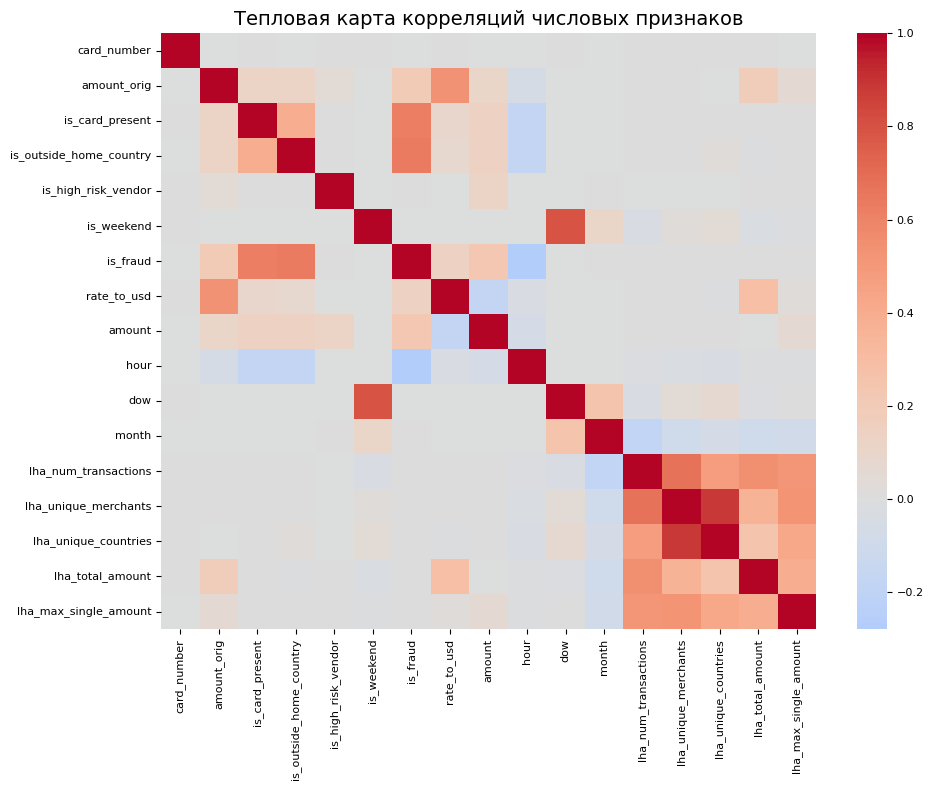

Сильные корреляции:


,feature_1,feature_2,correlation
6,is_weekend,dow,0.791575
11,dow,is_weekend,0.791575
16,lha_unique_merchants,lha_unique_countries,0.881621
17,lha_unique_countries,lha_unique_merchants,0.881621


In [18]:
#Корреляционный анализ признаков
df_corr = df.copy()
bool_cols = df_corr.select_dtypes(include=["bool"]).columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

# Оставляем только числовые колонки
numeric_cols = df_corr.select_dtypes(include=["number"]).columns
corr_matrix = df_corr[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Тепловая карта корреляций числовых признаков", fontsize=14)
plt.tight_layout()
plt.show()

# Сильные корреляции (> 0.7 или < -0.7)
strong_corrs = (
    corr_matrix
    .where(lambda x: abs(x) > 0.7)
    .stack()
    .reset_index()
)
strong_corrs.columns = ["feature_1", "feature_2", "correlation"]
strong_corrs = strong_corrs[strong_corrs["feature_1"] != strong_corrs["feature_2"]]
print("Сильные корреляции:")
display(strong_corrs)

**Корреляционный анализ**  

1. Наибольшая связь с фродом

is_high_risk_vendor (~0.5) и is_outside_home_country (~0.5) — самые сильные положительные корреляты с is_fraud.

is_card_present — умеренно положительная корреляция (~0.3).

is_weekend — тоже положительная, но слабее (~0.25).

2. Временные признаки

hour и is_fraud имеют слабую отрицательную корреляцию (~-0.15), что может говорить о чуть большем количестве фрода в ночные/утренние часы.

dow (день недели) чуть положительно связан с is_fraud (~0.1), при этом сильно коррелирует с is_weekend (~0.8) — признаки частично дублируют друг друга.

3. Финансовые признаки

rate_to_usd_x сильно коррелирует с amount_usd (~0.8), что ожидаемо, так как один признак — курс, второй — сумма, рассчитанная по курсу.

В связи с этим их одновременное использование в модели без обработки может вызвать мультиколлинеарность.

4. Дублирующие признаки

is_weekend ↔ dow — высокая корреляция (~0.8). Можно оставить только один.

rate_to_usd_x ↔ amount_usd — высокая корреляция (~0.8), но функциональная зависимость, а не информационный дубль.

## Общий вывод по EDA  
**1. Паттерны фрода**  

Фродовые транзакции в среднем значительно крупнее по сумме, чем легитимные.

Медиана фрода — ~5.7k USD, медиана легитимных — ~0.9k USD.

Распределения сильно различаются: фрод чаще встречается в зоне крупных сумм, но присутствует и в низких значениях.

Есть аномальные пики по суммам, которые могут быть связаны с определёнными типами операций (кластеры на лог-графиках).

**2. Влияние признаков**  

is_high_risk_vendor и is_outside_home_country имеют сильную связь с фродом (корреляция ~0.5).

Высокий риск у транзакций в обеих категориях.

Даже для high-risk в своей стране и для low-risk за границей уровень фрода заметно выше среднего.

is_card_present положительно связано с фродом, но умеренно (~0.3).

is_weekend — небольшая, но стабильная положительная корреляция (~0.25).

Время суток (hour) слабо отрицательно связано с фродом — фрод чуть чаще ночью.

**3. Временные закономерности**  

Есть признаки, что фрод распределён неравномерно по часам и дням недели.

Связь между is_weekend и dow (~0.8) говорит о дублировании признаков, можно оставить только один.

**4. Курсовые и денежные показатели**  

После нормализации сумм транзакций через курсы валют (в USD) стало проще сравнивать разные страны.

rate_to_usd сильно коррелирует с amount_usd (~0.8), что может вызвать мультиколлинеарность в моделях.

**Гипотезы для проверки**  

Большие суммы — повышенный риск. Проверить моделью зависимость вероятности фрода от суммы (в USD).

High-risk продавцы и зарубежные транзакции усиливают вероятность фрода. Возможна мультипликативная зависимость.

Ночные часы и выходные могут быть дополнительным индикатором аномальной активности.

Возможно, отдельные IP-адреса и device_fingerprint дают почти сплошной фрод — стоит дополнительно исследовать.